# Lab exercise - wave radiation and diffraction
In this notebook we will consider experiments in the wave laboratory, where a ship section will be tested. Two hydrodynamic problems are considered: 
* First, the heave radiation problem will be studied, where the model is forced to perform harmonic oscillations in heave in calm water. The objective of this test is to obtain the hydrodynamic radiation forces (added mass and damping). 
* Second, the diffraction problem will be considered, where the model is fixed and exposed to regular beam sea waves to determine wave excitation force in heave (sum of Froude-Kriloff and diffraction forces).

## Preparations
Preparations prior to lab visit:
When model experiments are planned, it is very important to be well prepared before going to the lab. One should have a clear view of the research questions - what do you seek with the experiments?, what can go wrong?, what do you need to be aware of (precautions)?

## Model and setup
The model is a mid-ship cross-section of a conventional displacement vessel with rounded bilges.

|Parameter   |	Symbol|	Value|	Unit|
|------------|--------|------|------|
|Beam        |	B     |	0.50 |	m   |
|Draft       |	T     |	0.125|	m   |
|Length      |	L     |	0.59 |	m   |
|Bilge radius|	R     |	0.025|	m   |

<div>
<img src="Figures/model_v2.PNG" width="300">
</div>

The model is mounted to a vertical actuator on the tank carriage. The model is located in the middle of the tank, at a distance $x_{model}=7.0$ m from the wavemaker.
<div>
<img src="Figures/lab_setup.PNG" width="700">
</div>


In [5]:
# Model particulars:
rho=1000. # [kg/m^3]
g = 9.81 # [m/s^2]
L = 0.59 # [m]
B = 0.50 # [m]
d = 0.15 # [m]
M = rho*L*B*d # [kg] structural mass is assumed equal to the displacement (bilge radius neglected)

# Model position from wavemaker
modelpos = 7. # [m]

## Post processing
We start all post-processing of data by loading the data-set and inspecting the data by plotting the raw measurements as time-series. Here we will make use of the python package pandas when working with time-series.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import postprocessing as pp

datapath = "//neptun.marin.ntnu.no/davidkr/TMR4247/lab/data/numpy"

datafile = "test2.npz"  # Enter the name of your data-file here..

# Import data as pandas DataFrame
df = pp.importDataFrame(datapath, datafile)

# We take a look at the first rows of data. Each measurement signal is stored column-wise
print(df.head())

   Time  1 - default sample rate   Pos_Rig  FY 20265  FZ 20266  Accc_m_20641  \
0                          0.000  0.000009 -0.005802  0.148413      0.000418   
1                          0.005  0.000009 -0.013152  0.142019      0.000361   
2                          0.010  0.000010 -0.025530  0.116631      0.000808   
3                          0.015  0.000010 -0.022146  0.071964      0.000985   
4                          0.020  0.000011 -0.008220  0.031782      0.000636   

            WP2  
0 -2.416667e-06  
1 -7.250000e-07  
2 -1.208333e-07  
3 -1.329167e-06  
4 -3.020833e-06  


Looking at the dataframe above, we see that it might be convenient to rename the columns with simpler names. Further, we are informed that the actuator signal "Pos_Rig" is the stroke of the actuator defined positive downwards. We will reverse the sign to consider the vertical (heave) motion of the model, with positive direction upwards.

In [2]:
# Let's rename the columns using the new names below:
columnnames=df.keys()
newnames=['Time', 'eta3', 'F2', 'F3', 'acc3', 'WP2']
column_names = dict(zip(df.keys(), newnames))  # This creates a dictionary with {oldname: newname}
df.rename(columns=column_names, inplace=True)

# Reverse the sign to convert actuator stroke to heave motion.
df['eta3'] = -df['eta3']

#Set the column named "Time" as the index. This makes it possible to select data based on time values, instead of using row indices
df.set_index("Time", inplace=True)

# Now let us have a look at the data:
print(df.head())

           eta3        F2        F3      acc3           WP2
Time                                                       
0.000 -0.000009 -0.005802  0.148413  0.000418 -2.416667e-06
0.005 -0.000009 -0.013152  0.142019  0.000361 -7.250000e-07
0.010 -0.000010 -0.025530  0.116631  0.000808 -1.208333e-07
0.015 -0.000010 -0.022146  0.071964  0.000985 -1.329167e-06
0.020 -0.000011 -0.008220  0.031782  0.000636 -3.020833e-06


Text(0.5, 0, 'Time [s]')

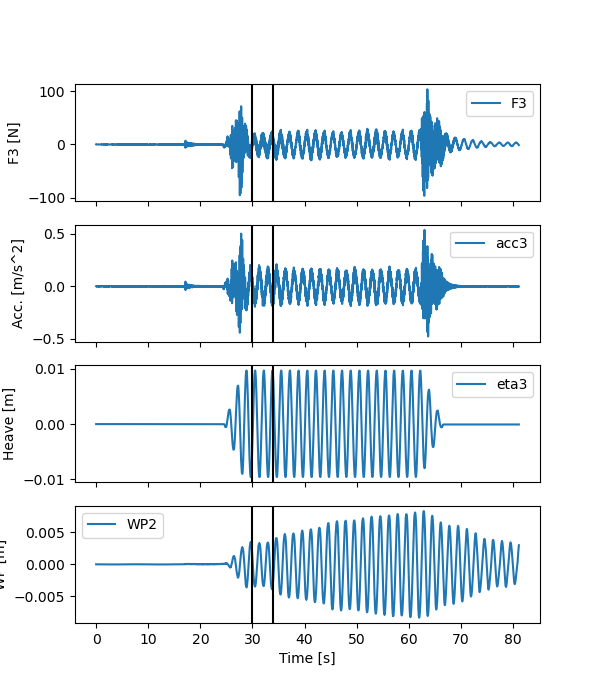

In [3]:
# Uncomment the line below if you will activate interactive plotting
%matplotlib widget
# Uncomment the line below if you will go back to in-line plotting
#%matplotlib inline 

#Looking at the time column, we see that data are sampled every 0.005 s.
#Sampling frequency
dt = 0.005 # [s] time between samples
fs = 1/dt # [Hz] sampling frequency

tstart = 30 # Define start of time-window for estimation of steady state values
tstop = 34  # Define end of time-window


# To get an overview of our measurements, the first thing to do is to plot the time-series: 
fig, ax = plt.subplots(4, 1, figsize=(6, 7), sharex=True) # Create fig handle with four axis
df.plot(ax=ax[0], y='F3') # the data is plotted against x="Time" which we have set to be the index
ax[0].axvline(tstart, color='k') # add vertical line to indicate start time-window
ax[0].axvline(tstop, color='k') # add vertical line to indicate stop time-window
ax[0].set_ylabel('F3 [N]')

df.plot(ax=ax[1], y='acc3')
ax[1].axvline(tstart, color='k') # add vertical line to indicate start time-window
ax[1].axvline(tstop, color='k') # add vertical line to indicate stop time-window
ax[1].set_ylabel('Acc. [m/s^2]')

df.plot(ax=ax[2], y='eta3')
ax[2].axvline(tstart, color='k') # add vertical line to indicate start time-window
ax[2].axvline(tstop, color='k') # add vertical line to indicate stop time-window
ax[2].set_ylabel('Heave [m]')

df.plot(ax=ax[3], y='WP2')
ax[3].axvline(tstart, color='k') # add vertical line to indicate start time-window
ax[3].axvline(tstop, color='k') # add vertical line to indicate stop time-window
ax[3].set_ylabel('WP [m]')
ax[3].set_xlabel('Time [s]')


We see from the figure above that the raw signals contain some noise, in particular the acceleration and force measurements. A common procedure is to filter the data with a *low-pass filter*. This means that we filter away all high frequency components above a given threshold (cut-frequency) and let the low frequency components pass the filter. When defining the cut frequency, we must be sure that we don't remove "physical" frequencies associated with the waves. We will use $f_{cut}=5$Hz in the following.

In [7]:
# Let's filter the data using a low-pass filter to remove high frequency noise
fcut=5 # [Hz] cut frequency
df_filtered = pp.filterDataFrame(df, fcut, fs)

Text(0.5, 0, 'Time [s]')

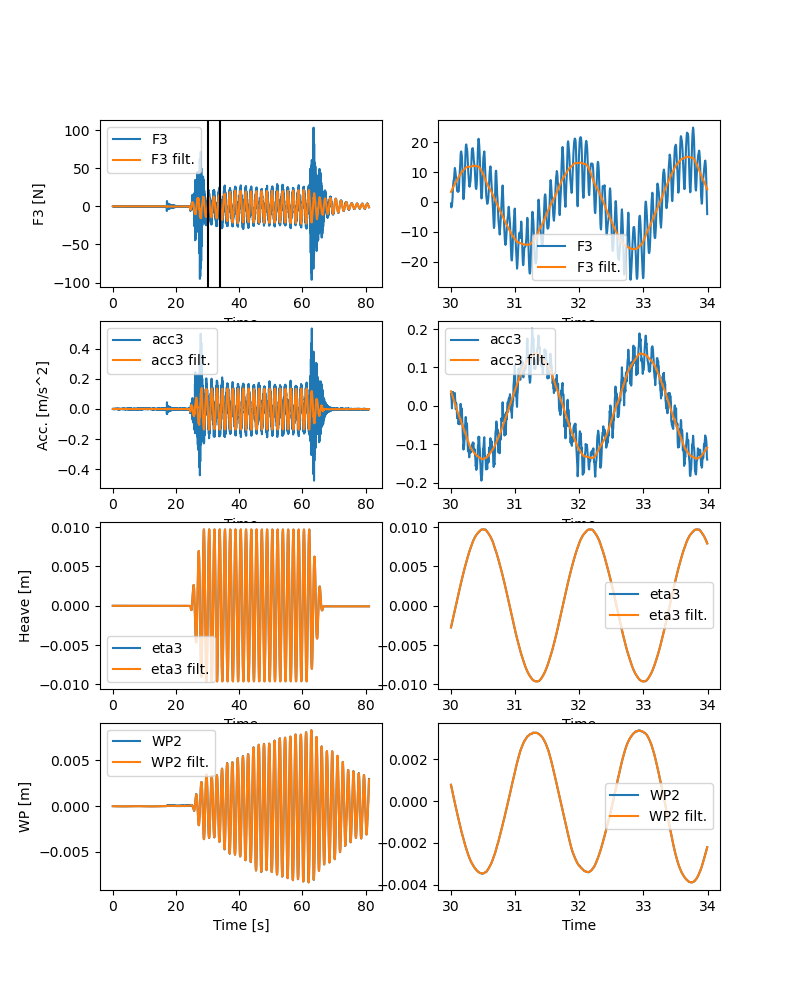

In [8]:
#%matplotlib widget # Uncomment this line if you will activate interactive plotting
#%matplotlib inline # Uncomment this line if you will go back to in-line plotting

# We will also have a closed look at a given window of the time-series, e.g. between tstart and tstop.
tstart = 30 # Define start of time-window for estimation of steady state values
tstop = 34  # Define end of time-window
df1 = df.loc[tstart:tstop]
df1_filt = df_filtered.loc[tstart:tstop]

# Create figure handle with four rows and two columns (eight plots)
gs_kw = dict(width_ratios=[2, 1], height_ratios=[1, 1])
fig, ax = plt.subplots(4, 2, figsize=(8, 10))

# Plot force, left
df.plot(ax=ax[0,0], y='F3')
df_filtered.plot(ax=ax[0,0], y='F3', label='F3 filt.')
ax[0,0].axvline(tstart, color='k') # add vertical line to indicate start time-window
ax[0,0].axvline(tstop, color='k') # add vertical line to indicate stop time-window
ax[0,0].set_ylabel('F3 [N]')

# Force zoomed, right
df1.plot(ax=ax[0,1], y='F3')
df1_filt.plot(ax=ax[0,1], y='F3', label='F3 filt.')

# Plot acceleration, left
df.plot(ax=ax[1,0], y='acc3')
df_filtered.plot(ax=ax[1,0], y='acc3', label='acc3 filt.')
ax[1,0].set_ylabel('Acc. [m/s^2]')

# Acc. zoomed, right
df1.plot(ax=ax[1,1], y='acc3')
df1_filt.plot(ax=ax[1,1], y='acc3', label='acc3 filt.')

# Plot heave motion, left
df.plot(ax=ax[2,0], y='eta3')
df_filtered.plot(ax=ax[2,0], y='eta3', label='eta3 filt.')
ax[2,0].set_ylabel('Heave [m]')

# Heave zoomed, right
df1.plot(ax=ax[2,1], y='eta3')
df1_filt.plot(ax=ax[2,1], y='eta3', label='eta3 filt.')

# Plot wave elevation, left
df.plot(ax=ax[3,0], y='WP2')
df_filtered.plot(ax=ax[3,0], y='WP2', label='WP2 filt.')
ax[3,0].set_ylabel('WP [m]')

# Wave zoomed, right
df1.plot(ax=ax[3,1], y='WP2')
df1_filt.plot(ax=ax[3,1], y='WP2', label='WP2 filt.')

# Add x-axis label to last row
ax[3,0].set_xlabel('Time [s]')


We want to use the measurements to obtain derived quantities, like the inertia force and restoring force. Assume the mass of the object considered is $M=40$kg. The inertia force in the vertical direction is then found as $I_3=M\ddot{\eta}_3$. Let us compute the inertia force.

In [17]:
import airywavelib as aw

# Get oscillation period from the mesaurements
Tper = pp.getZeroUpcrossingPeriod(df1.index.values, df1_filt['eta3'].values)
print("Wave period: T={:.3f} s".format(Tper))
omega = 2*np.pi/Tper
print("Wave frequency: omega={:.3f} s".format(omega))

# Corresponding wavenumber
h = 1.0
k = aw.findWaveNumber(omega, waterDepth=h)

# Group velocity for finite water depth
Cg = 0.5*omega/k*(1.0 + k*h/(np.sinh(k*h)*np.cosh(k*h)))

reflectiontime = 2 * (modelpos/Cg) # Time for the wave front to propagate from the model to the wavemaker and back
print("Group velocity: Cg={:.3f} m/s".format(Cg))
print("Time before wave reflection: {:.2f} s".format(reflectiontime))


Wave period: T=1.667 s
Wave frequency: omega=3.769 s
Group velocity: Cg=1.517 m/s
Time before wave reflection: 9.23 s


After ensuring that we don't have wave reflections in our selected time-window, we can extract the hydrodynamic forces from the measured force applied on the model from the actuator.

Text(0, 0.5, 'Force [N]')

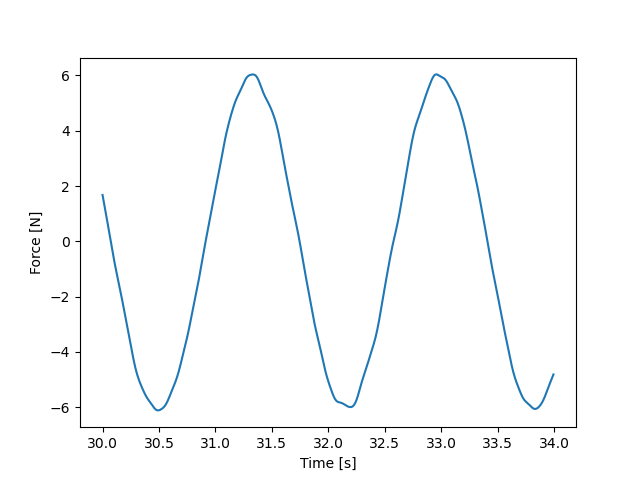

In [18]:
# Inertia force (mass times acceleration):
F_inertia = M*df1_filt['acc3'].values

plt.figure()
plt.plot(df1_filt.index.values, F_inertia)
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')

In [20]:
C33 = rho*g*L*B # Restoring coefficient (water-plane stiffness)

# Hydrodynamic force
Fhd = -df1_filt['F3'].values + M*df1_filt['acc3'].values + C33*df1_filt['eta3'].values

# Velocity in heave deduced from differentiation of the heave motion
eta3dot = np.diff(df1_filt['eta3'].values)/dt

# Let us have a look at the phase between -Fhd and the acceleration
plt.plot(df1_filt.index.values, -Fhd/np.max(Fhd), label=r"$-F_3^{HD}/\max(F_3^{HD})$")
plt.plot(df1_filt.index.values[:-1], eta3dot/np.max(eta3dot), label=r'$\dot{\eta}_3/\max(\dot{\eta}_3)$')
plt.plot(df1_filt.index.values, df1_filt['acc3'].values/np.max(df1_filt['acc3'].values), label=r'$\ddot{\eta}_3/\max(\ddot{\eta}_3)$')
plt.xlabel('Time [s]')
plt.grid('on')
plt.legend(fontsize=14)

We observe that the peaks of the negative hydrodynamic force $(-F_3^{hd})$ occur between peaks of acceleration and peaks of velocity. Meaning, the force has a phase angle relative to acceleration and relative to velocity. We introduce the negative sign, as the force is in oposite direction to the acceleration or velocity (it is a reaction force). As acceleration and velocity are orthogonal ($90^{\circ}$ out of phase), we can decompose the force into one component in phase with velocity and one component in phase with acceleration. Mathematically, we write:
$$F_{3}^{hd}=-A_{33}\ddot{\eta}_3-B_{33}\dot{\eta}_3$$
Next, we model the heave motion as $\eta_3=\eta_{3a}\cos(\omega t+\delta)$, where $\delta$ is a phase angle to be determined from the measured heave motion.

eta3a=0.010 m
delta=4.466 rad


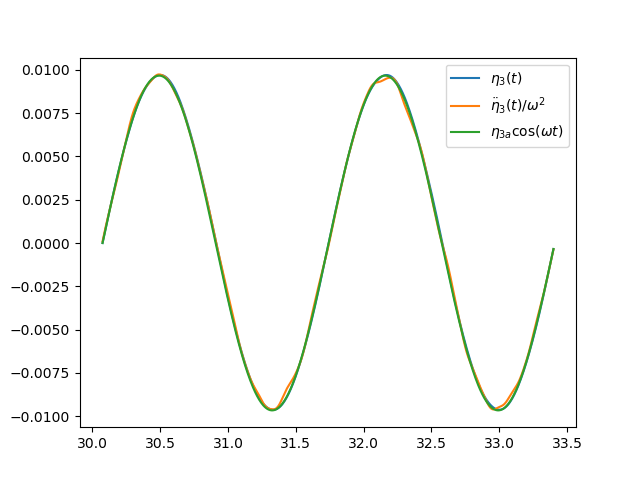

In [21]:
#locate zero upcrossings of measured heave (we then have two full cycles)
iups = np.ravel(np.argwhere(np.diff(np.sign(df1_filt['eta3'].values)) > 0))

nPer = len(iups)-1 # Number of oscillation periods

# Simple estimation of heave amplitude from first oscillation eta3a=0.5*(max(eta3)-min(eta3))
eta3a = 0.5*(np.max(df1_filt['eta3'].values[iups[0]:iups[1]])-np.min(df1_filt['eta3'].values[iups[0]:iups[1]]))

# Time vector
tvec = df1_filt.index[iups[0]:iups[-1]]

# Phase angle
delta = pp.getPhaseDifference(tvec, df1_filt['eta3'].iloc[iups[0]:iups[-1]], np.cos(omega*tvec)) * omega

print("eta3a={:.3f} m".format(eta3a))
print("delta={:.3f} rad".format(delta))

# Verify phase angle
fig0, ax0 = plt.subplots(1, 1)
ax0.plot(tvec, df1_filt['eta3'].iloc[iups[0]:iups[-1]], label=r'$\eta_3(t)$')
ax0.plot(tvec, -df1_filt['acc3'].iloc[iups[0]:iups[-1]]/omega**2, label=r'$\ddot{\eta}_3(t)/\omega^2$')
ax0.plot(tvec, eta3a*np.cos(omega*tvec + delta), label=r'$\eta_{3a}\cos(\omega t)$')
ax0.legend()

From the above figure we see that the modelled heave motion with the obtained phase angle and amplitude is consistent with measured heave motion and measured heave acceleration. Now we can decompose the hydrodynamic force into added mass and damping utilizing *orthogonal properties* of sine and cosine (the functions $f(x)$ and $g(x)$ are defined to be orthogonal if the integral of their product over some interval is zero, i.e. if $\int f(x)g(x)\mathrm{d}x=0$.), making the substitution 
$$\dot{\eta}_3(t)=-\omega\eta_{3a}\sin(\omega t)$$
$$\ddot{\eta}_3(t)=-\omega^2\eta_{3a}\cos(\omega t)$$
(here we have omitted the phase angle $\delta$ for brevity). Added mass is then found by multiplication of the hydrodynamic force by $\cos(\omega t)$ and integrate over $n$ oscillation periods:
$$\int_0^{nT}F_3^{hd}\cos(\omega t)\mathrm{d}t=-A_{33}\int_0^{nT}(-\omega^2 \eta_{3a}\cos(\omega t))\cos(\omega t)\mathrm{d}t - B_{33}\int_0^{nT}(-\omega \eta_{3a}\sin(\omega t))\cos(\omega t)\mathrm{d}t$$
As the force component proportional to $\sin(\omega t)$ becomes zero by integration due to ortogonality, this yields
$$A_{33}=\frac{\int_0^{nT}F_3^{hd}\cos(\omega t)\mathrm{d}t}{\omega\eta_{3a}n\pi}$$
Similarly, damping is found by multiplying the hydrodynamic force by $\sin(\omega t)$, and we obtain
$$\int_0^{nT}F_3^{hd}\sin(\omega t)\mathrm{d}t=-A_{33}\int_0^{nT}(-\omega^2 \eta_{3a}\sin(\omega t))\cos(\omega t)\mathrm{d}t - B_{33}\int_0^{nT}(-\omega \eta_{3a}\sin(\omega t))\sin(\omega t)\mathrm{d}t$$
which leads to
$$B_{33}=\frac{\int_0^{nT}F_3^{hd}\sin(\omega t)\mathrm{d}t}{\eta_{3a}n\pi}$$

In [22]:
import scipy.integrate as si  # We will use the trapeziodal method for numerical integration

# Compute added mass and damping coefficients
A33 = si.trapz(Fhd[iups[0]:iups[-1]] * np.cos(omega*tvec + delta), x=tvec) / (omega*eta3a*nPer*np.pi)
B33 = si.trapz(Fhd[iups[0]:iups[-1]] * np.sin(omega*tvec + delta), x=tvec) / (eta3a*nPer*np.pi)
print("omega={:.3f} rad/s, A33={:.3f} kg, B33={:.3f} kg/s".format(omega, A33, B33))
print("omega_hat={:.3f} [-], Ca33={:.3f} [-], Cb33={:.3f} [-]".format(omega*np.sqrt(B/(2*g)), A33/M, B33/M*np.sqrt(B/(2*g))))
print("omega*delta t: {}".format(omega*0.25))

omega=3.769 rad/s, A33=80.974 kg, B33=244.270 kg/s
omega_hat=0.602 [-], Ca33=1.830 [-], Cb33=0.881 [-]
omega*delta t: 0.9421741188590811


         x  a33_Bd2d_1_bem  a33_Bd2d_2_bem
0  0.05269          3.8162             NaN
1  0.06890          3.3693             NaN
2  0.08916          2.9140             NaN
3  0.12766          2.4581          4.9953
4  0.16008          2.1665          4.3742


Text(0, 0.5, '$b_{33}^{2D}$')

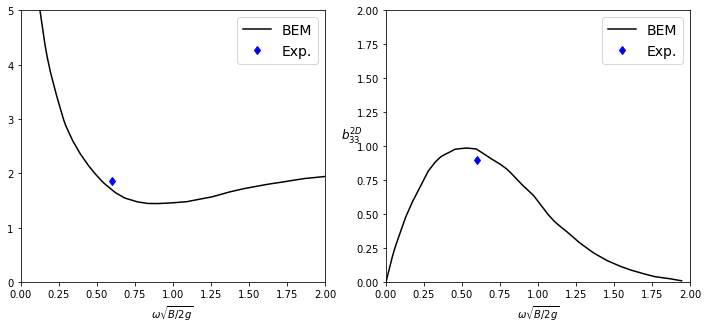

In [132]:
# Import numerical data for comparison (digitized from figure 3-20 in the compendium)
a33data = pd.read_csv("Data/Addedmass_2d_bem.csv", dtype=float, decimal=',')
b33data = pd.read_csv("Data/Damping_2d_bem.csv", dtype=float, decimal=',')

# Verify phase angle
fig2, ax2 = plt.subplots(1, 2, figsize=(12,5))
a33data.plot(ax=ax2[0], x='x', y='a33_Bd2d_2_bem', color='k', label='BEM')
ax2[0].plot(omega*np.sqrt(B/(2*g)), A33/M, 'bd', label='Exp.')
ax2[0].set_ylim(ymin=0., ymax=5.)
ax2[0].set_xlim(xmin=0., xmax=2.)
ax2[0].set_xlabel(r"$\omega\sqrt{B/2g}$")
ax2[1].set_ylabel(r"$a_{33}^{2D}$", rotation=0, fontsize=12)
ax2[0].legend(fontsize=14)

b33data.plot(ax=ax2[1], x='x', y='b33_Bd2d_2_bem', color='k', label='BEM')
ax2[1].plot(omega*np.sqrt(B/(2*g)), B33/M*np.sqrt(B/(2*g)), 'bd', label='Exp.')
ax2[1].set_ylim(ymin=0, ymax=2.0)
ax2[1].set_xlim(xmin=0, xmax=2.0)
ax2[1].legend(fontsize=14)
ax2[1].set_xlabel(r"$\omega\sqrt{B/2g}$")
ax2[1].set_ylabel(r"$b_{33}^{2D}$", rotation=0, fontsize=12)



## Diffraction problem
Next we consider the diffraction problem, where the model is clamped (restrained from moving) while exposed to beam sea regular waves.

In [93]:
# Import data from diffraction test as pandas DataFrame
df2 = pp.importDataFrame(datapath, "test6.npz") # Not available yet...

# We take a look at the first rows of data. Each measurement signal is stored column-wise
print(df2.head()) # The data below is not from diffraction test...

   Time  1 - default sample rate   Pos_Rig  FY 20265  FZ 20266  Accc_m_20641  \
0                          0.000  0.000011  0.411483  0.355715     -0.001587   
1                          0.005  0.000011  0.397364  0.256168     -0.002956   
2                          0.010  0.000011  0.310522  0.026819     -0.002749   
3                          0.015  0.000013  0.219812 -0.225054     -0.002824   
4                          0.020  0.000014  0.109568 -0.341971     -0.001907   

        WP2  
0 -0.000662  
1 -0.000662  
2 -0.000662  
3 -0.000648  
4 -0.000635  


Estimate the Froude-Kriloff force on the ship section. The velocity potential for a regular wave on finite water depth according to linear wave theory is
$$\phi(x,z,t)=\frac{g\zeta_a}{\omega}\frac{\cosh(k(z+h))}{\cosh(kh)}\sin(kx-\omega t)$$
Implement your expression for the Froude-Kriloff force *amplitude* in the code-block below. You can neglect the rounded bilges in your calculations and consider the model as a box with sharp edges.

### Solution
Using the given velocity potential, the dynamic pressure is found from Bernoulli's equation as
$$p(x,z,t)=-\rho\frac{\partial \phi}{\partial t}=\rho g \zeta_a\frac{\cosh(k(z+h))}{\cosh(kh)}\cos(kx-\omega t)$$
The Froude-Kriloff force is found by integration of the pressure over the mean wetted hull surface.
$$F_3^{FK}=-\int_S p(x,z,t)n_3\mathrm{d}s\approx -L\int_{x=-B/2}^{B/2} p(x, -T, t)(-1)\mathrm{d}x$$
The result is
$$F_3^{FK}= 2\rho g \zeta_a L\frac{\cosh(k(h-T))}{\cosh(kh)}\sin(\frac{kB}{2})\cos(\omega t)$$

In [163]:
def computeFroudeKriloff(omega, k, A, h, B, T):
    '''
    Compute Froude-Kriloff force in heave.
    param [in] omega: [rad/s] Wave frequency
    param [in] k: [rad/m] Wave number
    param [in] A: [m] Wave amplitude
    param [in] h: [m] Water depth
    param [in] B: [m] Model beam
    param [in] T: [m] Model draft
    
    return F3fk_amp [N/m] Froude-Kriloff force amplitude in heave
    '''

    #pass # Put your code here (remove "pass")
    
    # Solution
    F3fk_amp = 2*rho*g*A*np.cosh(kvec*(h-T))/np.cosh(kvec*h)*np.sin(kvec*B/2)

    return F3fk_amp

(0.0, 1.9419509404482482)

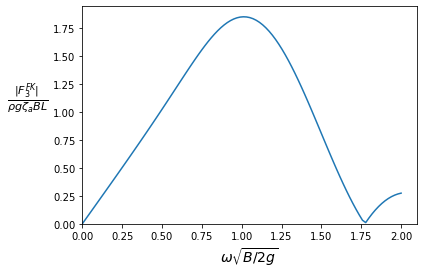

In [164]:
# Construct a nondimensional frequency array, spanning the same frequencies as the radiation problem.
omghat = np.linspace(0.001, 2, 100)
omgvec = omghat/np.sqrt(B/(2*g)) # [rad/s] wave frequency

# Create array of wavenumbers for given wave frequencies and waterdepth in the wave tank
kvec = np.array([aw.findWaveNumber(omega_i, waterDepth=h) for omega_i in omgvec]) # Iterate over frequency array

Avec = np.ones_like(kvec) # Unit wave amplitudes

# Vertical Froude-Kriloff force amplitude (per unit length):
F3fk_amp = computeFroudeKriloff(omgvec, kvec, Avec, h, B, T)

# We don't need interactive plotting here...
%matplotlib inline 

# Plot results
fig3 = plt.figure()
plt.plot(omghat, np.abs(F3fk_amp)/(rho*g*A*B))
plt.xlabel(r"$\omega\sqrt{B/2g}$", fontsize=14)
plt.ylabel(r"$\frac{|F_3^{FK}|}{\rho g\zeta_a BL}$", rotation=0, fontsize=16, labelpad=25)
plt.xlim(xmin=0)
plt.ylim(ymin=0)

Look at the comparison above. What is the difference between the measured excitation force and the Froude-Kriloff force?